In [1]:
sc

In [2]:
lts = sc.textFile('data/transm150720.csv')

In [3]:
lts.first()

u'79062005698500,TKTT,30,150719,FR,0.0,EUR,T,T,141025,PARA127A8,0.0,EUR,   ,EX,,150719,0.0'

In [4]:
def getTCNFechaCompra(l):
    e = l.split(',')
    tcn = e[0]
    fechaCompra = e[9]
    return(tcn, fechaCompra)

In [5]:
getTCNFechaCompra(lts.first())

(u'79062005698500', u'141025')

In [6]:
#tickets
ts = lts.map(getTCNFechaCompra)

In [7]:
ts.take(3)

[(u'79062005698500', u'141025'),
 (u'79062005924069', u'150719'),
 (u'79065668570385', u'150626')]

In [ ]:
#Cupones

In [8]:
lcs = sc.textFile('data/coupon150720.csv')

In [18]:
lcs.first()

u'79062005698500,1,MAA,AUH,9W,9W,56.79,USD,1,H,H,0526,150904,OK,IAF0'

In [19]:
def getTCNFechaSalida(l):
    e = l.split(',')
    tcn = e[0]
    fechaSalida = e[12]
    return(tcn, fechaSalida)

In [20]:
cs = lcs.map(getTCNFechaSalida)

In [22]:
#vemos que hay claves repetidas
cs.take(3)

[(u'79062005698500', u'150904'),
 (u'79062005698500', u'150905'),
 (u'79062005924069', u'150721')]

In [25]:
cs.groupByKey().mapValues(lambda vs: vs).take(3)

[(u'79062005558463',
  <pyspark.resultiterable.ResultIterable at 0x7f9786ac8b90>),
 (u'79065668432713',
  <pyspark.resultiterable.ResultIterable at 0x7f9786ac8c10>),
 (u'79062005501193',
  <pyspark.resultiterable.ResultIterable at 0x7f9786ac8c90>)]

In [28]:
#cupones agrupados
cpgs = cs.groupByKey().mapValues(lambda vs: min(vs)).cache()

In [29]:
cpgs.take(3)

[(u'79062005558463', u'150801'),
 (u'79065668432713', u'150823'),
 (u'79062005501193', u'150720')]

In [26]:
from time import strptime
from time import mktime

In [30]:
j = cpgs.leftOuterJoin(ts).cache()

In [31]:
# Fecha de salida u'150720', Fecha de compra u'150719'
j.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [32]:
def difFechas(f1, f2):
    of1 = strptime(f1, "%y%m%d")
    of2 = strptime(f2, "%y%m%d")
    segs1 = mktime(of1)
    segs2 = mktime(of2)
    dif = segs1 - segs2
    return dif/(3600*24)

In [34]:
#filtrar fechas incorrectas (incompletas) x[1][0] => u'150720' y x[1][1] => u'150719'
fj = j.filter(lambda x: x[1][0] != '' and x[1][1] != '')

In [35]:
fj.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [36]:
#tenemos los días de antelación de compra
fj.mapValues(lambda v: difFechas(v[0], v[1])).take(3)

[(u'79062005994272', 1.0), (u'79065668614400', 5.0), (u'79062005501193', 1.0)]

In [37]:
#diferencias en días
d = fj.mapValues(lambda v: difFechas(v[0], v[1]))

In [38]:
#el groupBy no es válido ya que tenemos miles de registros dentro de cada grupo y pueden estar en varios cluster
d.groupBy(lambda x: x[1]).take(3)

[(0.0, <pyspark.resultiterable.ResultIterable at 0x7f9786ac80d0>),
 (750.0, <pyspark.resultiterable.ResultIterable at 0x7f978629e350>),
 (198.04166666666666,
  <pyspark.resultiterable.ResultIterable at 0x7f978629e3d0>)]

In [39]:
d.take(3)

[(u'79062005994272', 1.0), (u'79065668614400', 5.0), (u'79062005501193', 1.0)]

In [40]:
#le metemos un 1 por que es el elemento por el que vamos a contar
d.map(lambda x: (x[1], 1)).take(3)

[(1.0, 1), (5.0, 1), (1.0, 1)]

In [41]:
d.map(lambda x: (x[1], 1)).reduceByKey(lambda e, accum: e + accum).take(3)

[(0.0, 28366), (750.0, 1), (198.04166666666666, 126)]

In [ ]:
#0.0, 28366 tickets con 0 días de antelació
#Error: 750.0, 1 Es imposible comprar un billete con más de 1 año de antelación

In [46]:
d.map(lambda x: (int(x[1]), 1)).reduceByKey(lambda e, accum: e + accum).take(3)

[(0, 28366), (515, 1), (5, 16793)]

In [47]:
r = d.map(lambda x: (int(x[1]), 1)).reduceByKey(lambda e, accum: e + accum)

In [48]:
r.take(3)

[(0, 28366), (515, 1), (5, 16793)]

In [50]:
#numero de diferentes días con compras de billetes
r.count()

452

In [51]:
res = r.collect()

In [52]:
len(res)

452

In [53]:
res[0:5]

[(0, 28366), (515, 1), (5, 16793), (10, 9906), (15, 7791)]

In [54]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [56]:
xs = [t[0] for t in res]

In [57]:
#eje x
xs[0:5]

[0, 515, 5, 10, 15]

In [58]:
ys = [t[1] for t in res]

In [59]:
#eje y
ys[0:5]

[28366, 1, 16793, 9906, 7791]

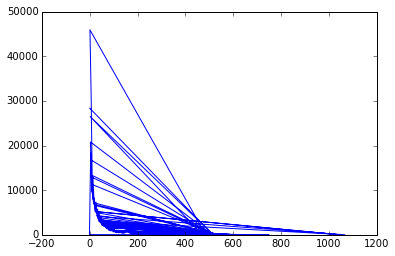

In [60]:
plt.plot(xs,ys)

<Container object of 452 artists>

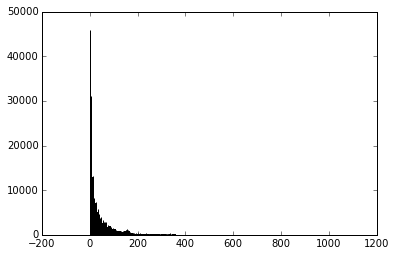

In [61]:
plt.bar(xs,ys)

(0, 90)

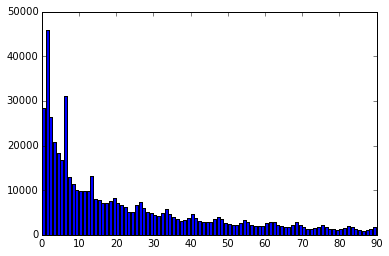

In [63]:
plt.bar(xs,ys)
plt.xlim(0,90)

#### Valor medio
#tickets
ts = lts.map(getTCNFechaCompra),hacer una función que se traiga además el importe de cada ticket